In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

# External library imports
import torch
import torch.nn as nn
import numpy as np
import random
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset, random_split
import json
import os
import matplotlib.pyplot as plt


# internal library imports

# internal library imports
from dataset import DebrisStateSeriesDataset
from model import ConvLSTM, ConvLSTMComplex, UNetLSTM
from train import TrainerSeries
from util.setting_utils import set_seed






In [2]:
# Set the random seed for multiple libraries to ensure repeatability

set_seed(42)

In [3]:
def read_losses(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    # Extract the subfolder name as the series name
    series_name = os.path.basename(os.path.dirname(file_path))
    return series_name, data['training_losses'], data['validation_losses']

def plot_multiple_losses(files):
    plt.figure(figsize=(12, 6))
    
    for file_path in files:
        series_name, training_losses, validation_losses = read_losses(file_path)
        epochs = range(1, len(training_losses) + 1)
        
        # plt.plot(epochs, training_losses, 'o-', label=f'{series_name} Training', linewidth=2)
        plt.plot(epochs, validation_losses, 'o--', label=f'{series_name} Validation', linewidth=2)

    plt.title('Training and Validation Losses for Multiple Models')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
# files = [
#     '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_CNN/losses_epoch_30.json',
#     '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_SmallUNet/losses_epoch_30.json',
#     '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_MedUNet/losses_epoch_30.json',
#     '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-21_base_model_comparison_l1Loss_batch32_LargeUNet/losses_epoch_30.json'
# ]

# plot_multiple_losses(files)

In [5]:
# files = [
#     '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-21_base_model_comparison_l1Loss_batch32_lr1e-4_CNN/losses_epoch_30.json',
#     '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-21_base_model_comparison_l1Loss_batch32_lr1e-4_SmallUNet/losses_epoch_30.json',
#     '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-21_base_model_comparison_l1Loss_batch32_lr1e-4_MedUNet/losses_epoch_30.json',
#     '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-21_base_model_comparison_l1Loss_batch32_lr1e-4_LargeUNet/losses_epoch_30.json'
# ]

# plot_multiple_losses(files)

In [6]:
# Parameters

root_dir = r'/home/tom/repos/dyna-landslide-surrogate/data_small'
checkpoint_dir = r'/home/tom/repos/dyna-landslide-surrogate/checkpoints'
batch_size = 64
split_proportions = (0.7, 0.15, 0.15)
epochs = 5
seq_length = 5  # Specify the sequence length for the ConvLSTMUNet
array_size = 256

in_channels = 3  # Number of input channels (e.g., terrain, velocity, thickness)
out_channels = 2  # Number of output channels (e.g., next velocity, next thickness)
hidden_dim = 64  # Hidden dimension of the ConvLSTM
kernel_size = (3, 3)  # Kernel size of the ConvLSTM

In [7]:
# Data set up

# Initialize dataset with scaling
dataset = DebrisStateSeriesDataset(root_dir=root_dir, array_size=array_size, apply_scaling=True, sequence_length=seq_length)

# Split dataset into train, validation, and test sets and create dataloaders
train_loader, val_loader, test_loader = dataset.create_dataloaders(split_proportions, batch_size, random_state=42)

# Dataset stats
print(f"Total dataset size: {len(dataset)}")
print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")

print(dataset.scaling_factors)

Total dataset size: 2509
Train size: 1774, Validation size: 328, Test size: 407
(0.0, 280.02, 0.0, 30.0, 0.0, 8.0)


In [8]:
# # Create an instance of each architecture
# cnn = CNN()
# small_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256])
# med_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512])
# large_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512, 1024])

# # Calculate the number of parameters for each architecture
# cnn_params = sum(p.numel() for p in cnn.parameters())
# small_unet_params = sum(p.numel() for p in small_unet.parameters())
# med_unet_params = sum(p.numel() for p in med_unet.parameters())
# large_unet_params = sum(p.numel() for p in large_unet.parameters())

# # Print the number of parameters for each architecture
# print("ComplexCNN parameters:", cnn_params)
# print("SimpleUNet parameters:", small_unet_params)
# print("LargeUNet parameters:", med_unet_params)
# print("UNet parameters:", large_unet_params)

In [12]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_lstm = UNetLSTM().to(device)

# Check if multiple GPUs are available and wrap the model using nn.DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    # This will wrap the model for use with multiple GPUs
    unet_lstm = nn.DataParallel(unet_lstm)

# Define the loss function and optimizer
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
# criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
optimizer = Adam(unet_lstm.parameters(), lr=1e-3)

unet_lstm_trainer = TrainerSeries(unet_lstm, optimizer, criterion, device, model_name="cnn", checkpoint_dir=checkpoint_dir)

unet_lstm_trainer.load_checkpoint("/home/tom/repos/dyna-landslide-surrogate/checkpoints/unet_lstm_test_int5_seq5_fulldataprune/model_epoch_5.pth", train_loader)

Using 2 GPUs!
Model loaded from /home/tom/repos/dyna-landslide-surrogate/checkpoints/unet_lstm_test_int5_seq5_fulldataprune/model_epoch_5.pth


In [13]:
unet_lstm_trainer.test(test_loader)

Test Loss: 0.0029


In [ ]:
# unet_lstm_trainer.plot_predictions(test_loader, num_predictions=5)

# THIS IS THE NEW STUFF TO TRY REGARDING INFER vs REAL

In [14]:
def plot_real_vs_inferred(real_states, inferred_states, n=5):
    num_timesteps = len(real_states)
    timesteps_to_plot = range(1, num_timesteps + 1, n)  # Start from 1 and go up to num_timesteps + 1

    for timestep in timesteps_to_plot:
        real_state = real_states[timestep]
        inferred_state = inferred_states[timestep]

        # Extract velocity and thickness from real and inferred states
        real_velocity = real_state[1]
        real_thickness = real_state[0]
        inferred_velocity = inferred_state[1]
        inferred_thickness = inferred_state[0]

        # Calculate differences
        velocity_diff = np.abs(real_velocity - inferred_velocity)
        thickness_diff = np.abs(real_thickness - inferred_thickness)

        plt.figure(figsize=(20, 8))

        # Row 1: Real Velocity, Inferred Velocity, Velocity Difference
        plt.subplot(2, 3, 1)
        plt.imshow(real_velocity, cmap='jet')
        plt.title(f'Real Velocity (Timestep {timestep})')
        plt.axis('off')
        plt.colorbar()

        plt.subplot(2, 3, 2)
        plt.imshow(inferred_velocity, cmap='jet')
        plt.title(f'Inferred Velocity (Timestep {timestep})')
        plt.axis('off')
        plt.colorbar()

        plt.subplot(2, 3, 3)
        plt.imshow(velocity_diff, cmap='jet')
        plt.title(f'Velocity Difference (Timestep {timestep})')
        plt.axis('off')
        plt.colorbar()

        # Row 2: Real Thickness, Inferred Thickness, Thickness Difference
        plt.subplot(2, 3, 4)
        plt.imshow(real_thickness, cmap='jet')
        plt.title(f'Real Thickness (Timestep {timestep})')
        plt.axis('off')
        plt.colorbar()

        plt.subplot(2, 3, 5)
        plt.imshow(inferred_thickness, cmap='jet')
        plt.title(f'Inferred Thickness (Timestep {timestep})')
        plt.axis('off')
        plt.colorbar()

        plt.subplot(2, 3, 6)
        plt.imshow(thickness_diff, cmap='jet')
        plt.title(f'Thickness Difference (Timestep {timestep})')
        plt.axis('off')
        plt.colorbar()

        plt.tight_layout()
        plt.show()

    # Stack all inferred arrays and all actual arrays
    stacked_inferred_velocity = np.stack([state[1] for state in inferred_states.values()], axis=0)
    stacked_inferred_thickness = np.stack([state[0] for state in inferred_states.values()], axis=0)
    stacked_real_velocity = np.stack([state[1] for state in real_states.values()], axis=0)
    stacked_real_thickness = np.stack([state[0] for state in real_states.values()], axis=0)

    # Plot stacked arrays side by side
    plt.figure(figsize=(20, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(stacked_real_velocity.max(axis=0), cmap='jet')
    plt.title('Stacked Real Velocity')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(2, 3, 2)
    plt.imshow(stacked_inferred_velocity.max(axis=0), cmap='jet')
    plt.title('Stacked Inferred Velocity')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(2, 3, 3)
    plt.imshow(np.abs(stacked_real_velocity.max(axis=0) - stacked_inferred_velocity.max(axis=0)), cmap='jet')
    plt.title('Stacked Velocity Difference')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(2, 3, 4)
    plt.imshow(stacked_real_thickness.max(axis=0), cmap='jet')
    plt.title('Stacked Real Thickness')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(2, 3, 5)
    plt.imshow(stacked_inferred_thickness.max(axis=0), cmap='jet')
    plt.title('Stacked Inferred Thickness')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(2, 3, 6)
    plt.imshow(np.abs(stacked_real_thickness.max(axis=0) - stacked_inferred_thickness.max(axis=0)), cmap='jet')
    plt.title('Stacked Thickness Difference')
    plt.axis('off')
    plt.colorbar()

    plt.tight_layout()
    plt.show()


def create_real_states_dict(root_dir, model_number, start_state, num_timesteps, array_size):
    real_states = {}
    
    model_dir = os.path.join(root_dir, str(model_number))
    velocity_dir = os.path.join(model_dir, f'04_FinalProcessedData_{array_size}', 'velocity')
    thickness_dir = os.path.join(model_dir, f'04_FinalProcessedData_{array_size}', 'thickness')
    
    for t in range(num_timesteps):
        state_number = start_state + t
        
        velocity_file = os.path.join(velocity_dir, f'{model_number}_velocity_{state_number}.npy')
        thickness_file = os.path.join(thickness_dir, f'{model_number}_thickness_{state_number}.npy')
        
        velocity = np.load(velocity_file)
        thickness = np.load(thickness_file)
        
        real_states[t + 1] = np.stack((thickness, velocity), axis=0)  # Change the key to t + 1
    
    return real_states

## roughly how to use

Does some weird stuff with the class though

Initial sequence shape: torch.Size([3, 256, 256])
Initial sequence device: cuda:0
Elevation shape: torch.Size([1, 256, 256])
Input tensor length: 5

Timestep: 0
Input sequence shape: torch.Size([1, 5, 3, 256, 256])
Next state shape: torch.Size([1, 2, 256, 256])
Inferred state shape at timestep 1: (2, 256, 256)
Next state with elevation shape: torch.Size([3, 256, 256])
Input tensor length after updating: 5

Timestep: 1
Input sequence shape: torch.Size([1, 5, 3, 256, 256])
Next state shape: torch.Size([1, 2, 256, 256])
Inferred state shape at timestep 2: (2, 256, 256)
Next state with elevation shape: torch.Size([3, 256, 256])
Input tensor length after updating: 5

Timestep: 2
Input sequence shape: torch.Size([1, 5, 3, 256, 256])
Next state shape: torch.Size([1, 2, 256, 256])
Inferred state shape at timestep 3: (2, 256, 256)
Next state with elevation shape: torch.Size([3, 256, 256])
Input tensor length after updating: 5

Timestep: 3
Input sequence shape: torch.Size([1, 5, 3, 256, 256])
Ne

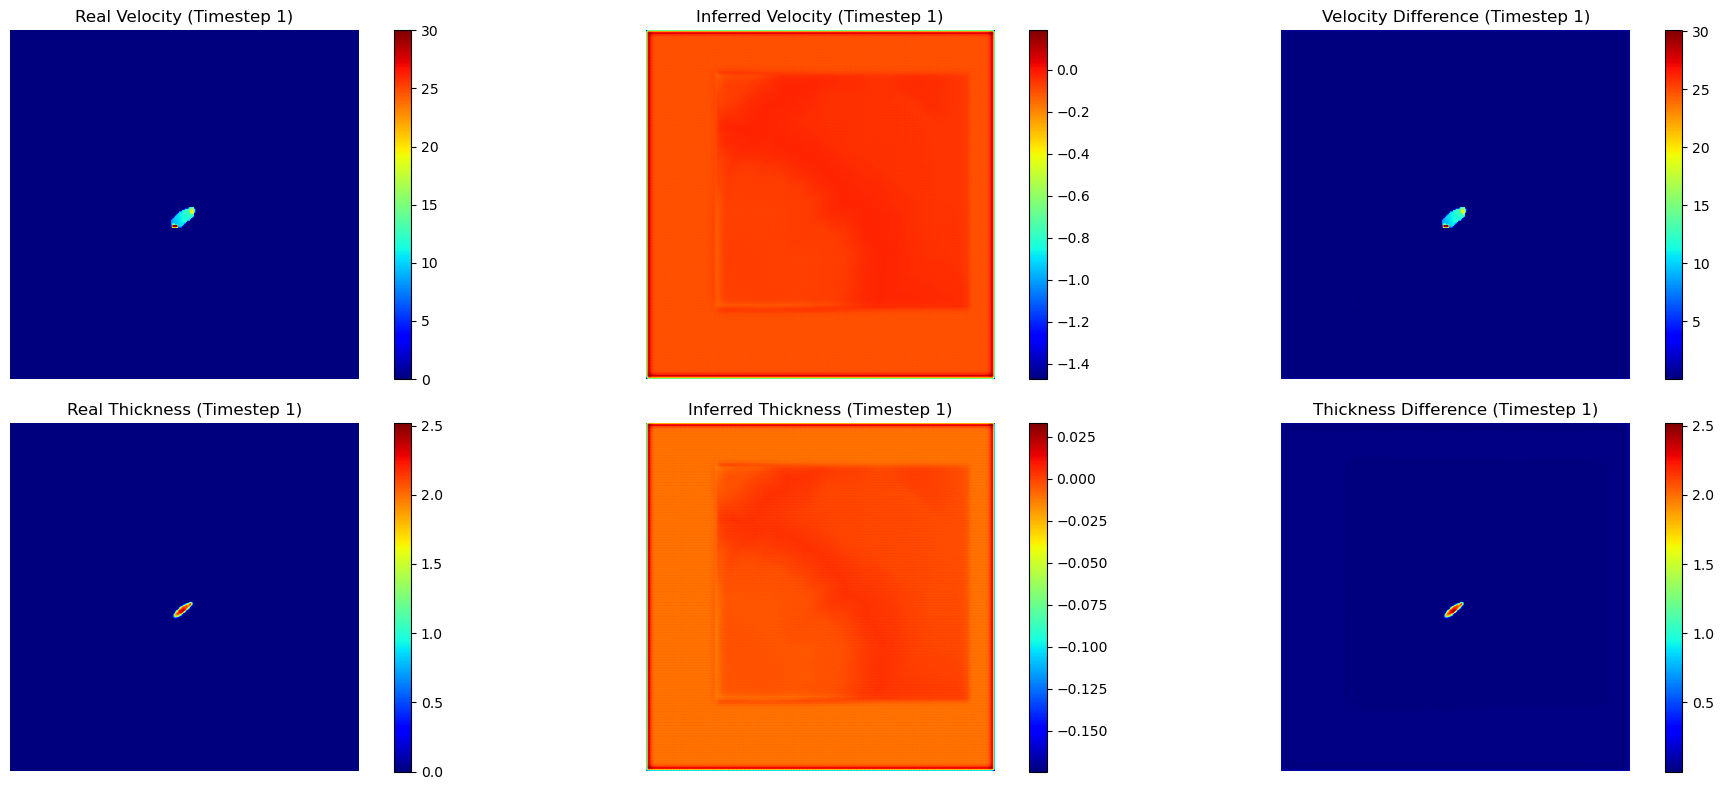

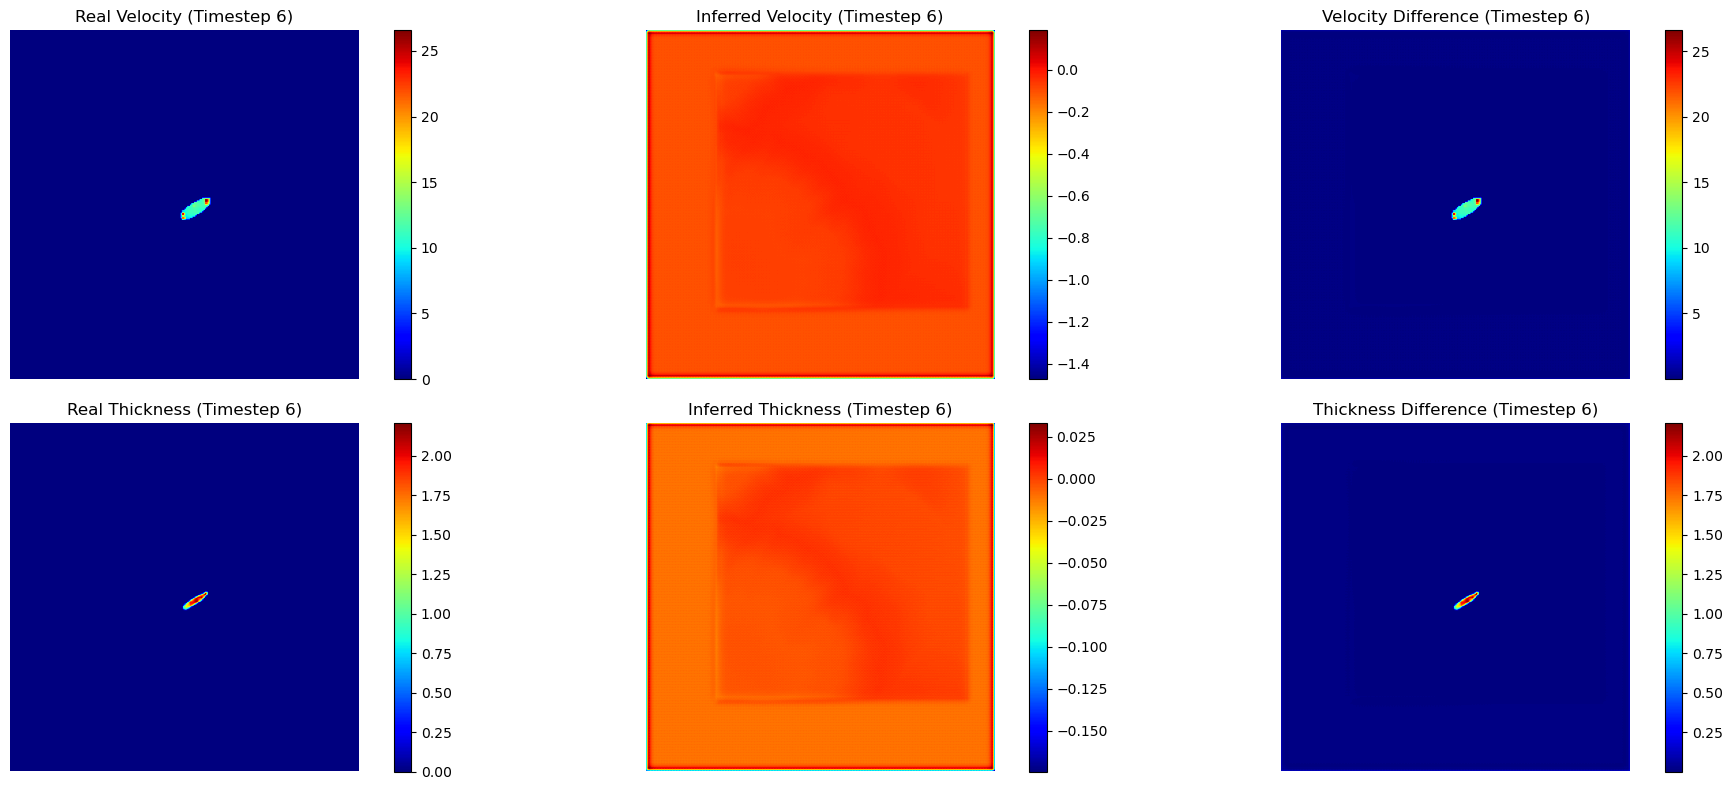

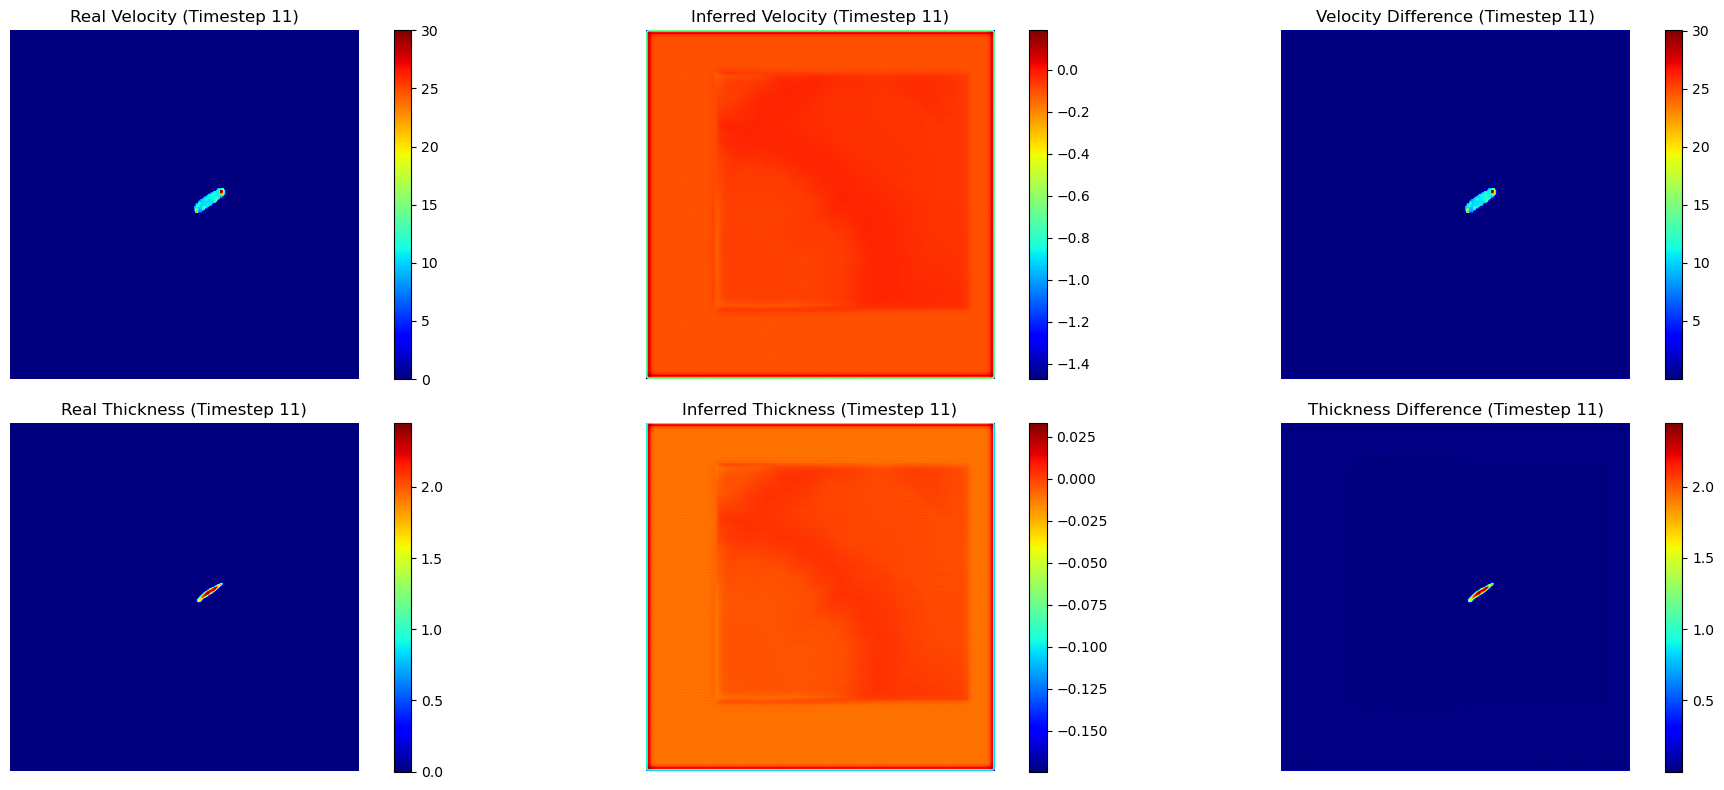

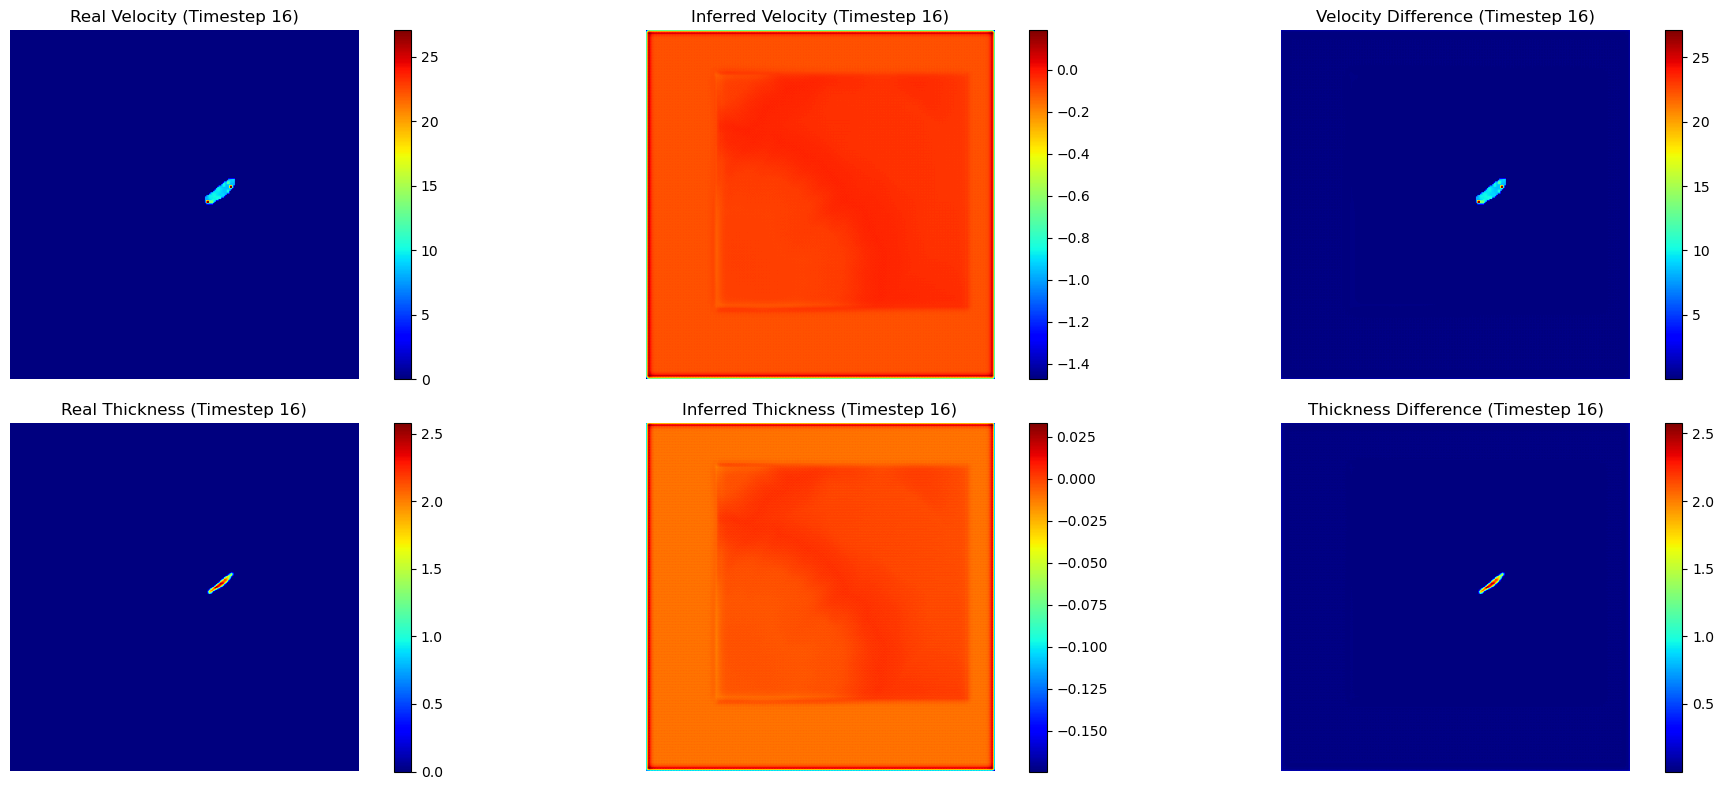

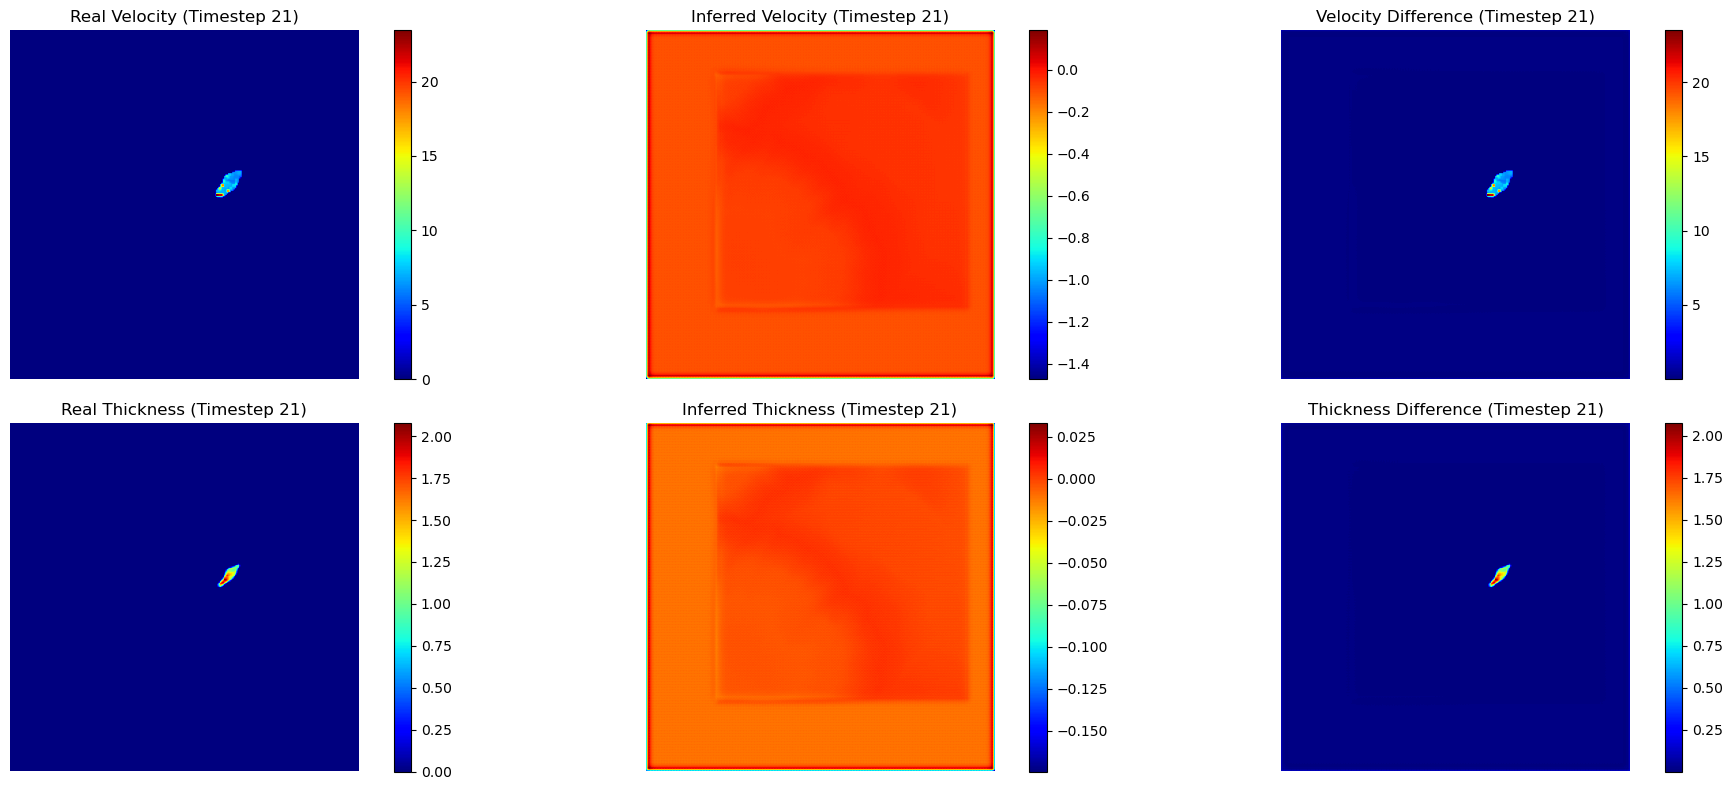

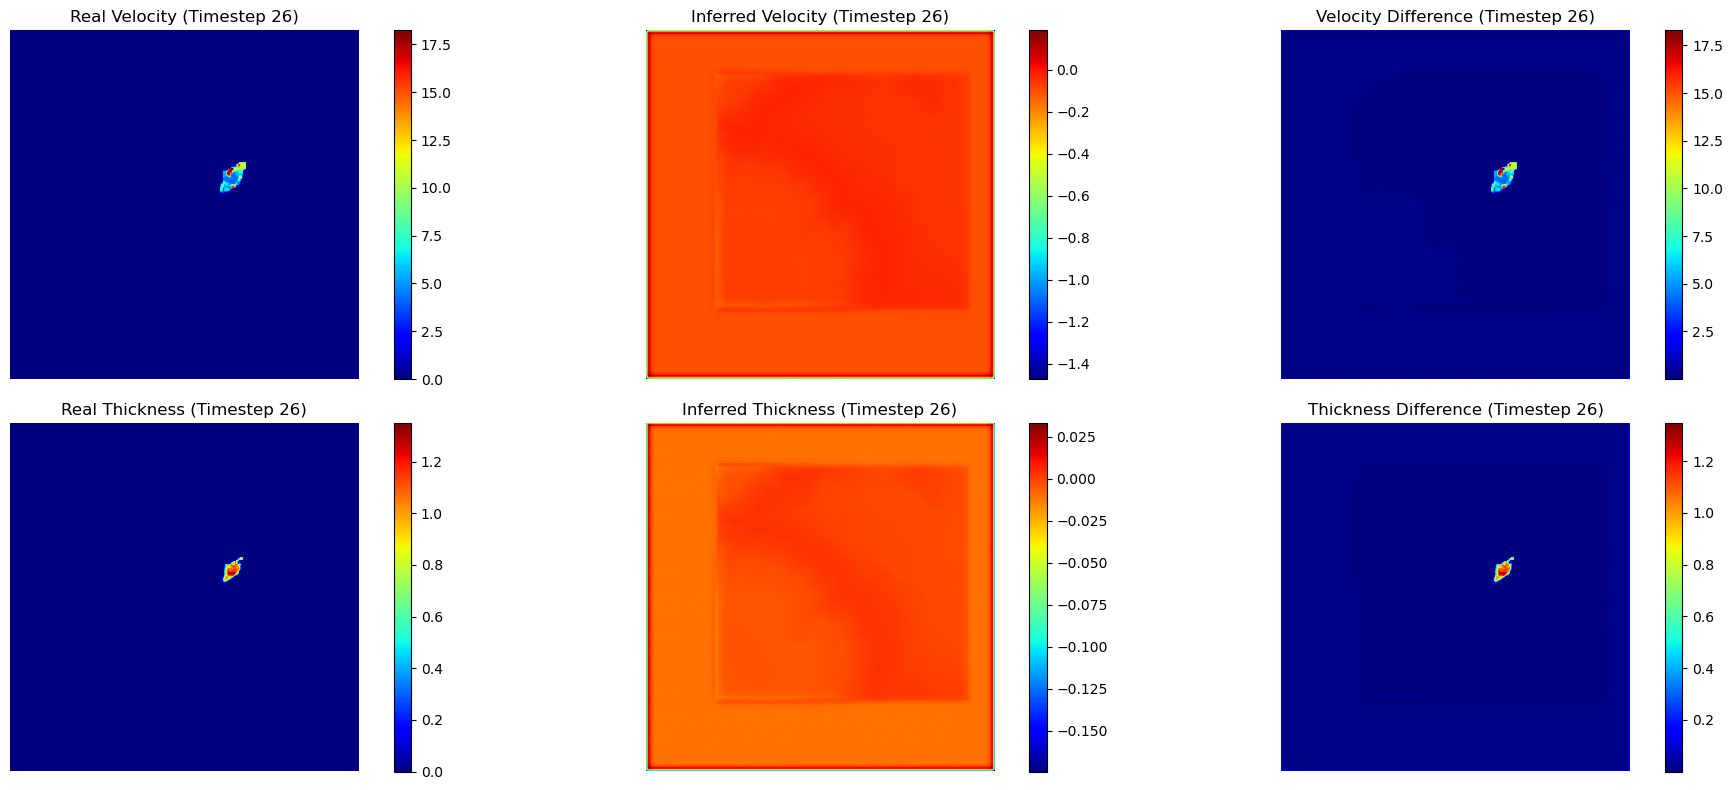

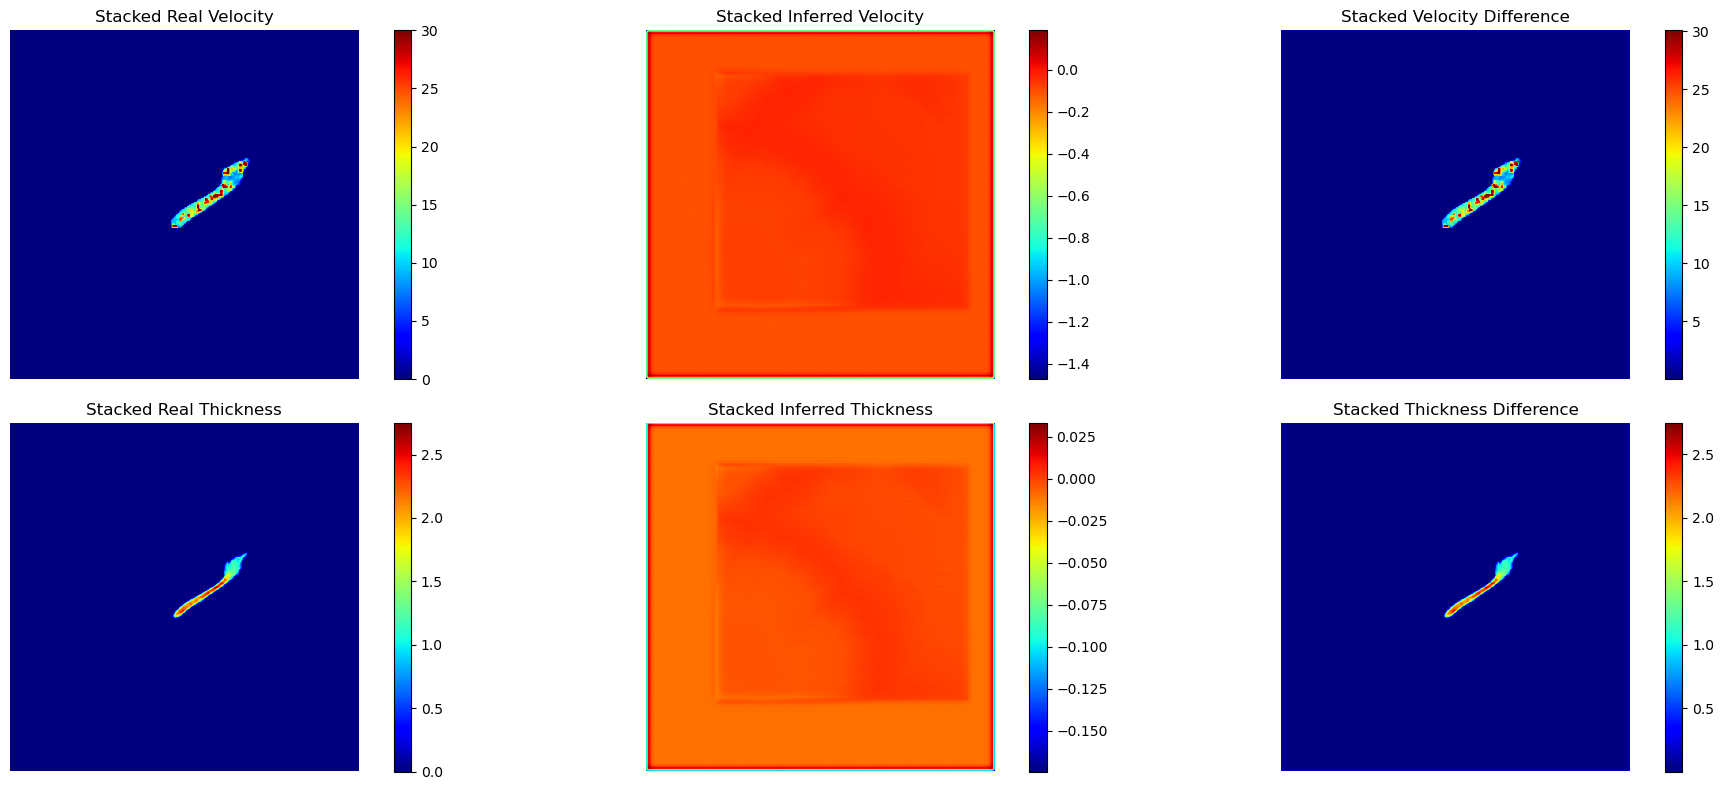

In [15]:
model_id = '00194'


# Create the initial input
initial_input = unet_lstm_trainer.create_inference_input(root_dir, model_id, 10, 256)



# Perform inference
num_timesteps = 30
inferred_states = unet_lstm_trainer.infer(initial_input, num_timesteps)

# Create the real states dictionary
real_states = create_real_states_dict(root_dir, model_id, num_timesteps+1, num_timesteps, 256)

# Plot real vs inferred states
plot_real_vs_inferred(real_states, inferred_states, n=5)

In [ ]:
type(initial_input)

torch.Tensor

In [ ]:
initial_input.shape

torch.Size([3, 256, 256])

In [ ]:
inferred_states

{1: array([[[-2.9265646e-02, -2.5332922e-02, -3.3295300e-02, ...,
          -2.4176104e-02, -3.7841242e-02, -6.0596019e-02],
         [-2.1681407e-02, -2.6553036e-03,  5.4286956e-03, ...,
           8.6683929e-03, -8.3378376e-03, -4.3963786e-02],
         [-1.7341955e-02,  4.4769882e-03,  1.5499842e-02, ...,
           4.5909109e-03, -9.3946997e-03, -3.1723749e-02],
         ...,
         [-1.7152494e-02,  9.9076040e-04,  9.4210152e-03, ...,
           1.7267579e-02,  3.4477116e-04, -3.6020365e-02],
         [-2.1237647e-02,  3.2317222e-03,  2.6911968e-02, ...,
           1.5187288e-02,  2.6437403e-03, -2.4065733e-02],
         [-2.7353425e-02, -1.5240461e-02,  1.5878916e-03, ...,
          -9.4570760e-03, -7.3402761e-03, -2.3735702e-02]],
 
        [[-5.3141540e-01, -4.4573411e-01, -4.0744504e-01, ...,
          -4.2914334e-01, -4.4789988e-01, -5.0997108e-01],
         [-3.7599340e-01, -2.2718874e-01, -1.7684953e-01, ...,
          -2.6192862e-01, -3.0972460e-01, -4.1193706e-01],
    

In [ ]:
inferred_states[1].shape

(2, 256, 256)

In [ ]:
for key, array in inferred_states.items():
    min_value = np.min(array)
    max_value = np.max(array)
    print(f"Min and max values for {key}: ({min_value}, {max_value})")

Min and max values for 1: (-0.5314154028892517, 4.4706244468688965)
Min and max values for 2: (-0.5886233448982239, 3.2044970989227295)
Min and max values for 3: (-0.7291771769523621, 2.257197141647339)
Min and max values for 4: (-0.8475931286811829, 2.211280584335327)
Min and max values for 5: (-0.9318982362747192, 2.503298044204712)
Min and max values for 6: (-1.0121031999588013, 2.7448606491088867)
Min and max values for 7: (-1.0491113662719727, 2.9360482692718506)
Min and max values for 8: (-1.0798088312149048, 3.088437795639038)
Min and max values for 9: (-1.214550256729126, 3.2203164100646973)
Min and max values for 10: (-1.3350337743759155, 3.312706470489502)
Min and max values for 11: (-1.446230173110962, 3.4180238246917725)
Min and max values for 12: (-1.4903571605682373, 3.4778687953948975)
Min and max values for 13: (-1.557631015777588, 3.5716426372528076)
Min and max values for 14: (-1.5752099752426147, 3.633612871170044)
Min and max values for 15: (-1.5991787910461426, 3.7

In [ ]:


# Create the initial input
initial_input = med_unet_trainer.create_inference_input(root_dir, '00204', 2, 256)

# Perform inference
num_timesteps = 30
inferred_states = med_unet_trainer.infer(initial_input, num_timesteps)

# Create the real states dictionary
real_states = create_real_states_dict(root_dir, '00204', 2 + 1, num_timesteps, 256)

# Plot real vs inferred states
plot_real_vs_inferred(real_states, inferred_states, n=5)

NameError: name 'med_unet_trainer' is not defined